**Step 1: Import libraries**

This imports core libraries for data analysis (pandas, numpy), visualization (matplotlib, seaborn), preprocessing (StandardScaler, LabelEncoder), and modeling (IsolationForest). Metrics like precision, recall, and F1-score are included to evaluate anomaly detection performance.

In [3]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


**Step 2: Load and Explore the Data**

The AI4I dataset is loaded from UCI’s repository and inspected with .head(), .info(), and .describe() to understand its structure. A missing value check ensures the dataset is clean before modeling.

In [4]:
# Step 2: Load and Explore the Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
df = pd.read_csv(url)

# Quick overview
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())

# Check missing values
print(df.isnull().sum())


(10000, 14)
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    

**Step 3: Feature Engineering**

Two new features are created: Temp_Diff (air – process temperature) to capture overheating effects, and Power (torque × rotational speed) to reflect mechanical load. Irrelevant IDs (UDI, Product ID) are dropped as they do not contribute to predictive power.

In [5]:
#Step 3: Feature Engineering
df["Temp_Diff"] = df["Air temperature [K]"] - df["Process temperature [K]"]
df["Power"] = df["Torque [Nm]"] * df["Rotational speed [rpm]"]

if "UDI" in df.columns:
    df.drop(columns=["UDI"], inplace=True)
if "Product ID" in df.columns:
    df.drop(columns=["Product ID"], inplace=True)


**Step 4: Exploratory Data Analysis (EDA)**

Histograms, correlation heatmaps, and boxplots are plotted to visualize distributions, correlations, and outliers. This step helps identify how engineered features behave and whether anomalies stand out in the data.

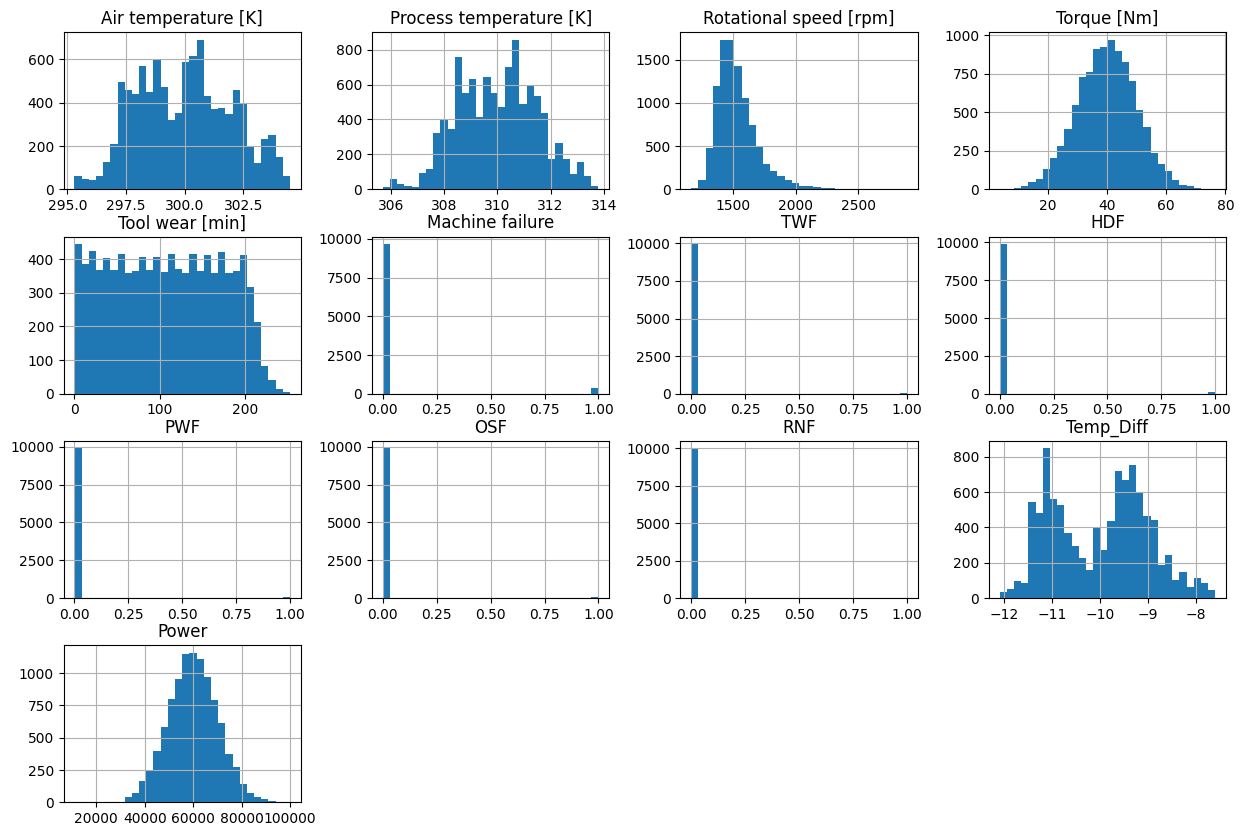

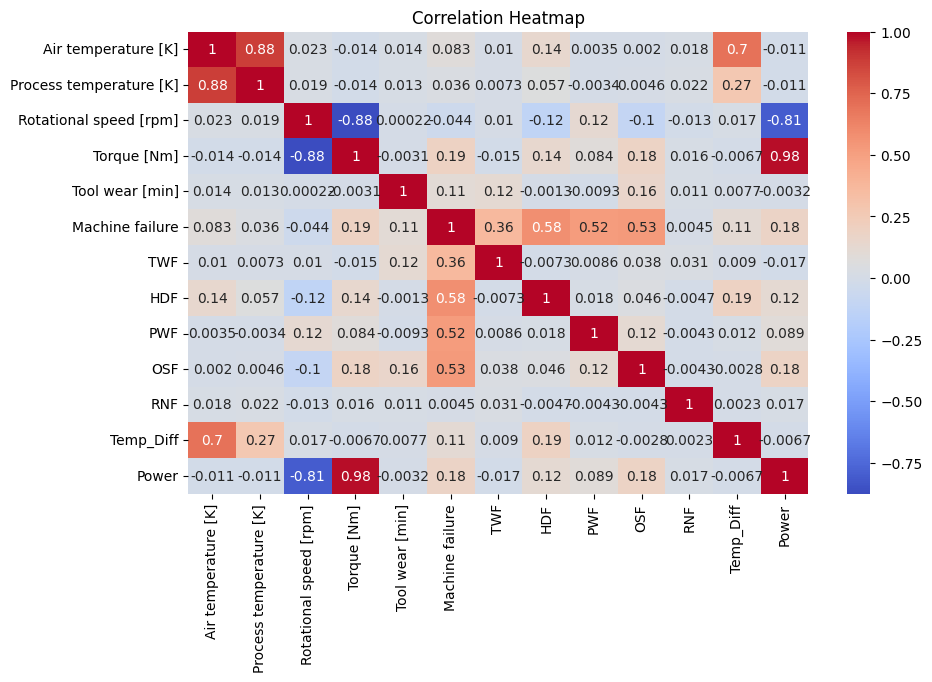

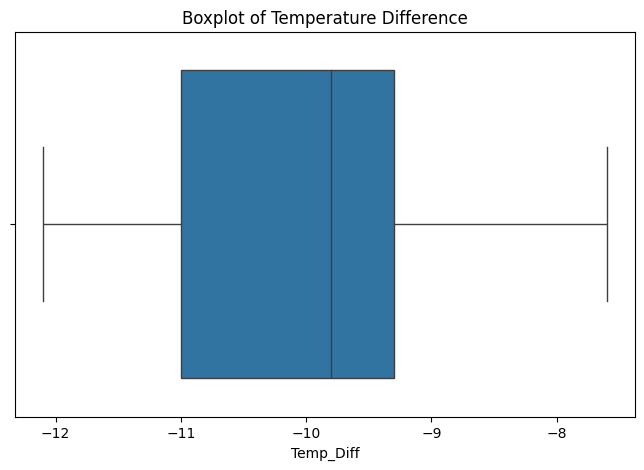

In [6]:
#Step 4: Exploratory Data Analysis (EDA)
df.hist(bins=30, figsize=(15,10))
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap="coolwarm", annot=True)
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=df["Temp_Diff"])
plt.title("Boxplot of Temperature Difference")
plt.show()


**Step 5: Data Preprocessing**

The categorical Type column is label-encoded into numeric form. All features are standardized using StandardScaler to ensure fair comparison across variables with different scales.

In [ ]:
#Step 5: Data Preprocessing
if "Type" in df.columns:
    le = LabelEncoder()
    df["Type"] = le.fit_transform(df["Type"])

# Separate features
X = df.drop(columns=["Machine failure"])
y = df["HDF"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data shape after preprocessing:", X_scaled.shape)


Data shape after preprocessing: (10000, 13)


**Step 6: Train Isolation Forest with Hyperparameter Tuning**

Isolation Forest is trained with different contamination values (expected anomaly proportion). For each setting, precision, recall, and F1-score are computed, and the best contamination rate is chosen based on F1-score.

In [ ]:
#Step 6: Train Isolation Forest with Hyperparameter Tuning

contamination_values = [0.01, 0.025, 0.05, 0.1]
results = {}
metrics_summary = []

for c in contamination_values:
    iso = IsolationForest(n_estimators=200, contamination=c, random_state=42)
    preds = iso.fit_predict(X_scaled)
    preds = np.where(preds == -1, 1, 0)  # 1 = anomaly

    results[c] = preds

    f1 = f1_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)

    metrics_summary.append({
        "contamination": c,
        "f1_score": f1,
        "precision": precision,
        "recall": recall
    })

metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)

# Select best contamination by F1
best_c = metrics_df.loc[metrics_df["f1_score"].idxmax(), "contamination"]
print(f"\n Best contamination value based on F1-score: {best_c}")


   contamination  f1_score  precision    recall
0          0.010  0.428246      0.940  0.277286
1          0.025  0.672326      0.792  0.584071
2          0.050  0.710369      0.596  0.879056
3          0.100  0.477969      0.320  0.943953

✅ Best contamination value based on F1-score: 0.05


**Step 7: Evaluate Final Model**

The final Isolation Forest is retrained with the best contamination value and evaluated using a confusion matrix, classification report, and ROC-AUC. This quantifies how well the model detects true failures while limiting false alarms.

In [ ]:
#Step 7: Evaluate Final Model
# Retrain final model
final_iso = IsolationForest(n_estimators=200, contamination=best_c, random_state=42)
final_preds = final_iso.fit_predict(X_scaled)
final_preds = np.where(final_preds == -1, 1, 0)

print("Confusion Matrix:\n", confusion_matrix(y, final_preds))
print("\nClassification Report:\n", classification_report(y, final_preds, digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y, final_preds):.4f}")


Confusion Matrix:
 [[9459  202]
 [  41  298]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9957    0.9791    0.9873      9661
           1     0.5960    0.8791    0.7104       339

    accuracy                         0.9757     10000
   macro avg     0.7958    0.9291    0.8488     10000
weighted avg     0.9821    0.9757    0.9779     10000

ROC-AUC Score: 0.9291


**Step 8: Visualize Anomalies**

Scatterplots of process vs. air temperature are used to visualize detected anomalies (red) against normal cases (blue). This provides an intuitive check on whether anomaly detection aligns with expected machine behavior.

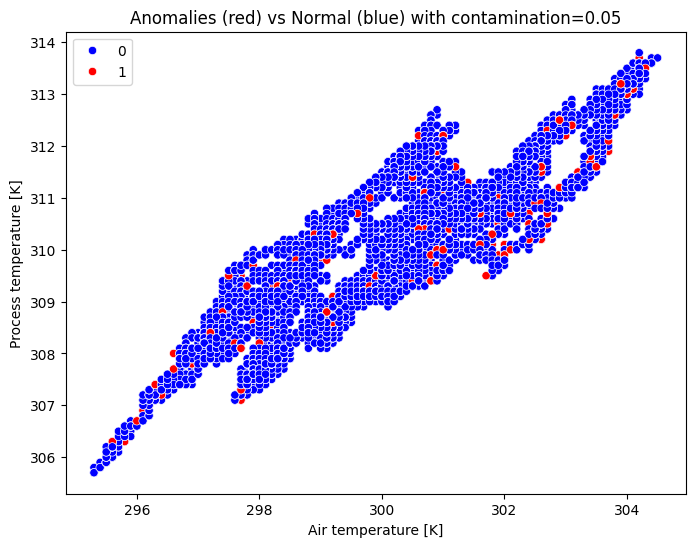

In [ ]:
#Step 8: Visualize Anomalies
plt.figure(figsize=(8,6))
sns.scatterplot(x=df["Air temperature [K]"],
                y=df["Process temperature [K]"],
                hue=final_preds,
                palette={0:"blue", 1:"red"})
plt.title(f"Anomalies (red) vs Normal (blue) with contamination={best_c}")
plt.show()


**Step 9: Save Final Model**

The trained Isolation Forest and the scaler are saved with joblib for future deployment. This allows consistent preprocessing and anomaly detection on new incoming machine data.

In [ ]:
# Step 9: Save Final Model


joblib.dump(final_iso, "final_isolation_forest.pkl")
joblib.dump(scaler, "scaler.pkl")

print(" Final model and scaler saved for deployment.")
